## Testing

##### Project Notes / Ideas

1. Try other forms of classification other than random forest
    - need multilclass classification models that return class probabilities (or binary classifiers using one v one / one v rest)


2. Could look at introducing number of goals to determine fixture results instead
    - would mean using regression rather than classification
    - would need to estimate predicted number of goals for home team based on home teams points %, away teams points %, home team form away team form
    - estimate would need to be done for away team expected goals using a second regression model
    - fixtures could be simulated using poisson model to generate number of home and away goals
    - could get probabilities for home win / draw / away win using the skellam distribution (compares 2 Poisson models)
    - could compare this model to the classification models performance at predicting results from past fixtures
    - probabilities from skellam distribution could be used for generating betting odds if goals model is used
    

3. Look at plotting progression of league position/points throughout the season using plots


4. Look at introducing the impact of form (e.g. results from last 3/5 games) into the model
    - need to impute form values for teams that have played less than the 3/5 games in the current season
    - use some form of regression/imputuation method (e.g. iterative imputation)
    - could predict form values based off points % from the previous year
    - may need to check correlation between points % and form values (check home and away values separately)


5. Potentially look at implementing part 2 of the suggested project lists (e.g. betting odds)


6. For betting, look at adjusting of odds based on volume of bets made
    - adjust odds if a large proportion of bets on any given game are on a particular result to cover the house (as is done in reality)


7. Could set proportions of bets for each game randomly (e.g. get random probabilities of betting on wins, draws and losses)


8. Could review distribution of bets after a certain number of bets are placed
    - e.g. review after 1000, 2000, 3000.... bets are placed
    - if bets are biased towards a particular outcome by a particular amount then betting odds could be readjusted
    - the proportion of bets probabilities could also be readjusted (people less likely to bet on an outcome if the odds decrease)
    - need to come up with a reasonable way of modelling this (rather than readjusting bet proportion probabilities directly, consider sanpling the value to scale them by from a normal distribution or similar with mean value equal to the value that would be directly proportional to the current distribution of bets)
    

9. Consider adjusting the %points total score of teams used to predict their performance in the next season by an amount dictated by some random variable
    - e.g. add value from narrow normal distribution with mean 0, small variance
    - most teams would not be impacted significantly, some may have significant positive or negative impact
    - could account for external factors that lead to unexpected under/overachieveing in a given season, such as an effective new signing or injury to a key player

In [238]:
import os
print(os.getcwd())

import pandas as pd
from pandas import DataFrame
import glob
import math
import numpy as np

/Users/fanahanmcsweeney/Projects/03-UCD-Summer-Trimester/ACM40960-ProjMathsModel/Reference


In [239]:
# Define data files path name
path = 'Data/'

In [240]:
dftest = pd.read_csv(path + 'EPL2003_2004.csv', usecols=['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG'])
len(dftest)

380

In [241]:
dftest = dftest[['HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG']]
dftest = dftest.dropna()
len(dftest)

380

In [242]:
dftest.head()

,HomeTeam,AwayTeam,FTR,FTHG,FTAG
0,Arsenal,Everton,H,2,1
1,Birmingham,Tottenham,H,1,0
2,Blackburn,Wolves,H,5,1
3,Fulham,Middlesbrough,H,3,2
4,Leicester,Southampton,D,2,2


In [243]:
filenames = sorted(glob.glob(path + "/*.csv"))

In [271]:
# create empty list to store data frames from each EPL season
li = []

# loop through all csv file names
for filename in filenames:
    # read in 'HomeTeam', 'AwayTeam', 'FTR' columns for current file, drop rows with NAs
    df = pd.read_csv(filename, usecols=['HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG']).dropna()
    # append dataframe from current EPL year to list
    li.append(df)

# combine all data frames in list into a single data frame
EPL_original = pd.concat(li, axis=0)
# reset row indices
#EPL_original.reset_index(drop=True, inplace=True)

In [272]:
# create copy of the EPL data frame so we can keep the originally loaded data frame if needed later
EPL = EPL_original.copy()
len(EPL)

9500

In [273]:
EPL.reset_index(drop=True, inplace=True)

In [274]:
# add columns to EPL to store '% of total points earned for the whole season' for home and away teams 
EPL['HomePPC'] = 0.0
EPL['AwayPPC'] = 0.0
## add columns to EPL to store form values for home and away teams (% points in past 5 games)
EPL['HomeForm5'] = 0.0
EPL['AwayForm5'] = 0.0

In [275]:
# get no. of seasons (number of files loaded)
num_seasons = len(filenames)
# get no. of games per season (20 teams choose 2, multiply by 2 for home/away fixtures)
games_per_season = math.comb(20, 2) * 2

In [276]:
# set start/end indices for the first season of fixtures
start_ind = 0
end_ind = games_per_season

# create empty dataframe to save season stats for every team for all seasons
all_seasons_WLD = DataFrame()

# loop through all 25 seasons worth of data
for season in range(0,num_seasons):
    # get list of unique teams in the current season
    teams = sorted(list(set(EPL['HomeTeam'].iloc[start_ind:end_ind])))

    # create dataframe with relevant columns, add teams as the 1st column
    WLD_cols = ['W','D','L','PointsTot','PointsPC']
    teams_WLD = DataFrame(columns=WLD_cols)
    teams_WLD.insert(0,"Team",teams)
    
    # loop through all teams in the current season
    for team in teams:
        # count total no. of wins/losses/draws for each team in the current season
        Ws = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='H')) | ((EPL[start_ind:end_ind]["AwayTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='A')))
        Ds = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) | (EPL[start_ind:end_ind]["AwayTeam"]==team)) & (EPL[start_ind:end_ind]["FTR"]=='D'))
        Ls = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='A')) | ((EPL[start_ind:end_ind]["AwayTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='H')))
        # count total number of points and % of overall points for each team
        Points = 3*Ws + 1*Ds
        PointsPC = Points / (38*3)
        # add season stats for current team to the dataframe, sort by highest points
        teams_WLD.loc[teams_WLD['Team']==team, WLD_cols] = [Ws, Ds, Ls, Points, PointsPC]
        teams_WLD = teams_WLD.sort_values('PointsTot', ascending=False)
    
    # add column for current season index
    teams_WLD.insert(0,"Season",season)
    
    # loop through each fixture in the current season
    for game in range(start_ind,end_ind):
        # add overall points % for the home and away teams in the current fixture
        home_pc = teams_WLD[teams_WLD['Team']==EPL.iloc[game,]['HomeTeam']]['PointsPC']
        away_pc = teams_WLD[teams_WLD['Team']==EPL.iloc[game,]['AwayTeam']]['PointsPC']
        EPL.at[game,'HomePPC']=home_pc
        EPL.at[game,'AwayPPC']=away_pc
        
    
    # add current season stats for each team to main dataframe
    all_seasons_WLD = all_seasons_WLD.append(teams_WLD)
    # increment start/end indices to correspond with fixtures for next season
    start_ind = start_ind + games_per_season
    end_ind = end_ind + games_per_season

In [277]:
EPL

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HomePPC,AwayPPC
0,Aston Villa,Man United,3.0,1.0,H,0.552632,0.719298
1,Blackburn,QPR,1.0,0.0,H,0.535088,0.289474
2,Chelsea,Everton,0.0,0.0,D,0.438596,0.535088
3,Liverpool,Sheffield Weds,1.0,0.0,H,0.622807,0.350877
4,Man City,Tottenham,1.0,1.0,D,0.333333,0.535088
...,...,...,...,...,...,...,...
9495,Leicester,Man United,0.0,2.0,A,0.543860,0.578947
9496,Man City,Norwich,5.0,0.0,H,0.710526,0.184211
9497,Newcastle,Liverpool,1.0,3.0,A,0.385965,0.868421
9498,Southampton,Sheffield United,3.0,1.0,H,0.456140,0.473684


In [279]:
EPL.corr()

,FTHG,FTAG,HomePPC,AwayPPC
FTHG,1.000000,-0.055936,0.301667,-0.229918
FTAG,-0.055936,1.000000,-0.227360,0.270913
HomePPC,0.301667,-0.227360,1.000000,-0.051334
AwayPPC,-0.229918,0.270913,-0.051334,1.000000


In [280]:
import seaborn as sns

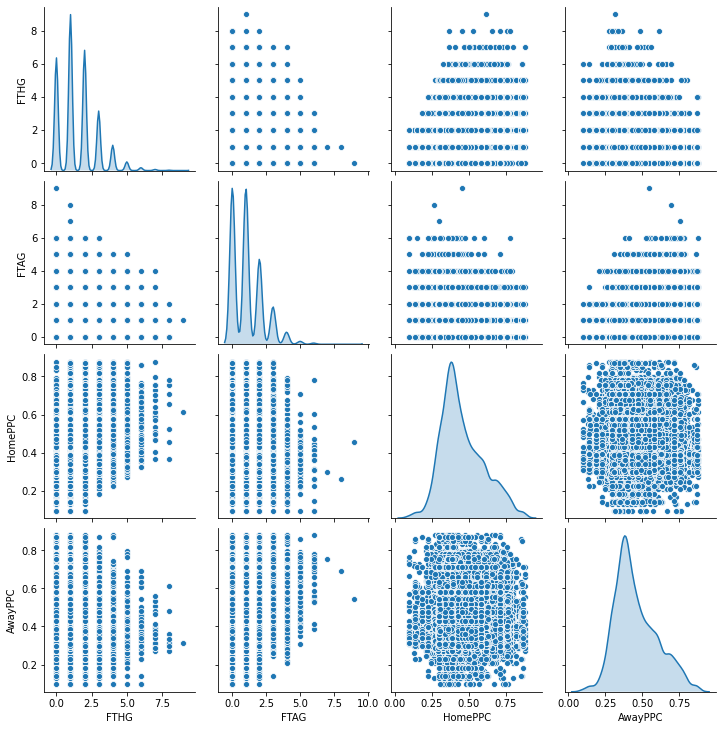

In [319]:
sns.pairplot(EPL, diag_kind="kde")

In [291]:
EPL.shape

(9500, 7)

In [376]:
EPL_NEW = EPL.copy()

In [377]:
EPL_NEW['FTHG']=EPL_NEW['FTHG']+(np.random.rand(9500)*1.0-0.5)
EPL_NEW['FTAG']=EPL_NEW['FTAG']+(np.random.rand(9500)*1.0-0.5)
EPL_NEW['Diff']=EPL_NEW['HomePPC']-EPL_NEW['AwayPPC']

In [378]:
EPL_NEW.corr()

,FTHG,FTAG,HomePPC,AwayPPC,Diff
FTHG,1.000000,-0.051051,0.295252,-0.225392,0.359050
FTAG,-0.051051,1.000000,-0.221006,0.262266,-0.333278
HomePPC,0.295252,-0.221006,1.000000,-0.051334,0.725029
AwayPPC,-0.225392,0.262266,-0.051334,1.000000,-0.725029
Diff,0.359050,-0.333278,0.725029,-0.725029,1.000000


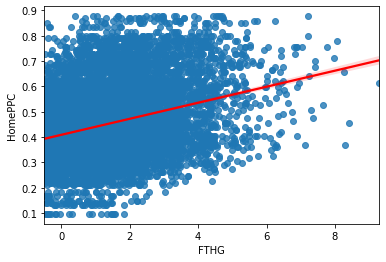

In [379]:
sns.regplot(x='FTHG', y='HomePPC', data=EPL_NEW, line_kws={"color":"red"})

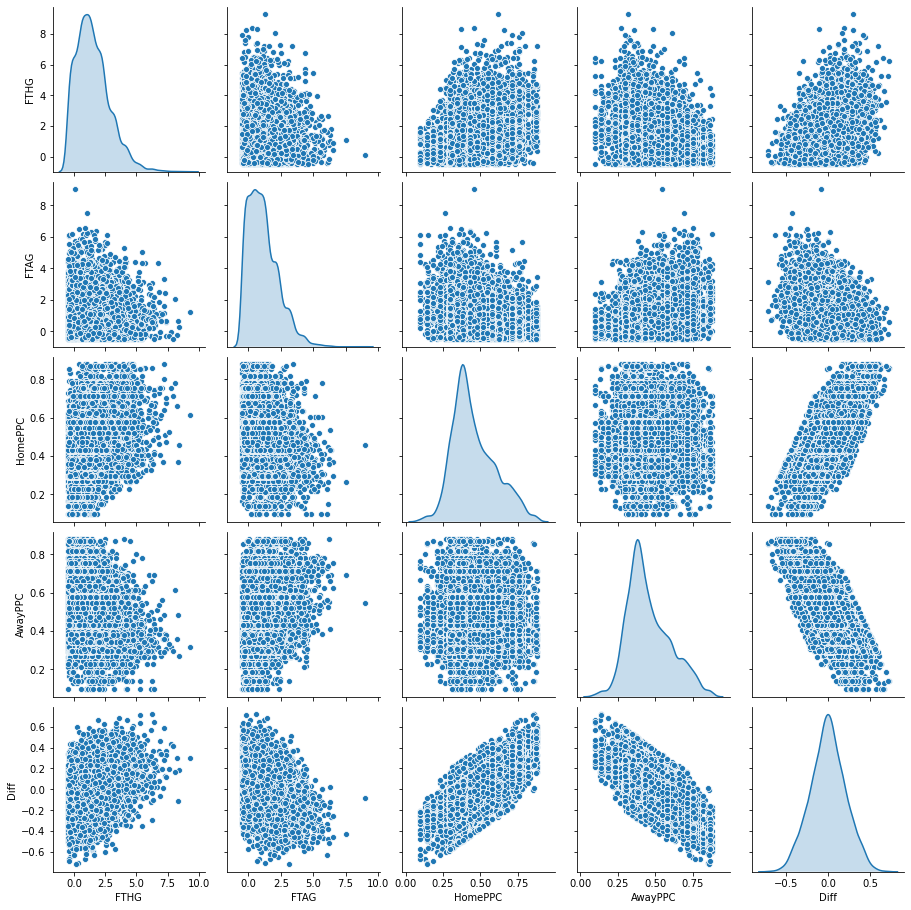

In [380]:
sns.pairplot(EPL_NEW, diag_kind="kde")

In [375]:
EPL_NEW[EPL_NEW['HomePPC']==EPL_NEW['AwayPPC']]['FTR'].value_counts()

H    87
D    71
A    54
Name: FTR, dtype: int64

In [543]:
# set start/end indices for the first season of fixtures
start_ind = 0
end_ind = games_per_season

# create empty dataframe to save season stats for every team for all seasons
all_seasons_WLD = DataFrame()

## create empty dataframes to save ppg / 5-game form stats for all seasons
all_seasons_ppg = DataFrame()
all_seasons_form = DataFrame()


# loop through all 25 seasons worth of data
for season in range(0,num_seasons):
    # get list of unique teams in the current season
    teams = sorted(list(set(EPL['HomeTeam'].iloc[start_ind:end_ind])))

    # create dataframe with relevant columns, add teams as the 1st column
    WLD_cols = ['W','D','L','PointsTot','PointsPC']
    teams_WLD = DataFrame(columns=WLD_cols)
    teams_WLD.insert(0,"Team",teams)
    
    
    ## create data frame to store points in each game
    teams_ppg = DataFrame(columns=range(1,39))
    teams_ppg.insert(0,"Team",teams)
    ## create data frame to store 5 game form
    teams_form = DataFrame(columns=range(1,39))
    teams_form.insert(0,"Team",teams)
    
    
    # loop through all teams in the current season
    for team in teams:
        # count total no. of wins/losses/draws for each team in the current season
        Ws = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='H')) | ((EPL[start_ind:end_ind]["AwayTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='A')))
        Ds = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) | (EPL[start_ind:end_ind]["AwayTeam"]==team)) & (EPL[start_ind:end_ind]["FTR"]=='D'))
        Ls = sum(((EPL[start_ind:end_ind]["HomeTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='A')) | ((EPL[start_ind:end_ind]["AwayTeam"]==team) & (EPL[start_ind:end_ind]["FTR"]=='H')))
        # count total number of points and % of overall points for each team
        Points = 3*Ws + 1*Ds
        PointsPC = Points / (38*3)
        # add season stats for current team to the dataframe
        teams_WLD.loc[teams_WLD['Team']==team, WLD_cols] = [Ws, Ds, Ls, Points, PointsPC]
    # sort by highest points
    teams_WLD = teams_WLD.sort_values('PointsTot', ascending=False)
    
    # add column for current season index
    teams_WLD.insert(0,"Season",season)
    
    ## add column for current season index
    teams_ppg.insert(0,"Season",season)
    teams_form.insert(0,"Season",season)
    
    # loop through each fixture in the current season
    for game in range(start_ind,end_ind):
        # add overall points % for the home and away teams in the current fixture
        home_pc = teams_WLD[teams_WLD['Team']==EPL.iloc[game,]['HomeTeam']]['PointsPC']
        away_pc = teams_WLD[teams_WLD['Team']==EPL.iloc[game,]['AwayTeam']]['PointsPC']
        EPL.at[game,'HomePPC']=home_pc
        EPL.at[game,'AwayPPC']=away_pc
        
        ## Get home and away team names
        hometeam = EPL.iloc[game,]['HomeTeam']
        awayteam = EPL.iloc[game,]['AwayTeam']
        ## determine points for home and away team (will remain 0 if team has lost)
        HomePts = AwayPts = 0
        if EPL.iloc[game,]['FTR'] == 'D':
            HomePts = AwayPts = 1
        elif EPL.iloc[game,]['FTR'] == 'H':
            HomePts = 3
        else :
            AwayPts = 3
            
        ## get next available game index of home team, add home team points to teams_ppg dataframe
        home_nextfree = teams_ppg.columns[(teams_ppg.loc[teams_ppg['Team']==hometeam,].isna()).iloc[0]].min()
        teams_ppg.loc[teams_WLD['Team']==hometeam, home_nextfree] = HomePts
        ## if team has already played at least 5 games, calculate form and also add to EPL dataframe
        if home_nextfree > 5:
            home_form5 = (teams_ppg[teams_ppg['Team']==hometeam]).iloc[:,(home_nextfree-4):(home_nextfree+1)].values.sum()/15.0
            teams_form.loc[teams_WLD['Team']==hometeam, home_nextfree] = home_form5
            EPL.at[game,'HomeForm5'] = home_form5
        
        ## get next available game index of away team, add away team points to teams_ppg dataframe
        away_nextfree = teams_ppg.columns[(teams_ppg.loc[teams_ppg['Team']==awayteam,].isna()).iloc[0]].min()
        teams_ppg.loc[teams_WLD['Team']==awayteam, away_nextfree] = AwayPts
        ## if team has already played at least 5 games, calculate form and also add to EPL dataframe
        if away_nextfree > 5:
            away_form5 = (teams_ppg[teams_ppg['Team']==awayteam]).iloc[:,(away_nextfree-4):(away_nextfree+1)].values.sum()/15.0
            teams_form.loc[teams_WLD['Team']==awayteam, away_nextfree] = away_form5
            EPL.at[game,'AwayForm5'] = away_form5
 
    # add current season stats for each team to main dataframe
    all_seasons_WLD = all_seasons_WLD.append(teams_WLD)
    
    ## add current season stats for each team to main dataframe
    all_seasons_ppg = all_seasons_ppg.append(teams_ppg)
    all_seasons_form = all_seasons_form.append(teams_form)
    
    # increment start/end indices to correspond with fixtures for next season
    start_ind = start_ind + games_per_season
    end_ind = end_ind + games_per_season

In [532]:
teams_ppg[teams_ppg['Team']=='Arsenal']

,Season,Team,1,2,3,4,5,6,7,8,...,29,30,31,32,33,34,35,36,37,38
0,24,Arsenal,3,3,0,1,1,3,1,3,...,0,0,3,3,3,1,0,3,0,3


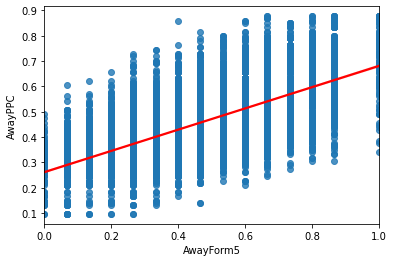

In [558]:
sns.regplot(x='AwayForm5', y='AwayPPC', data=EPL, line_kws={"color":"red"})

In [559]:
EPL.corr()

,FTHG,FTAG,HomePPC,AwayPPC,HomeForm5,AwayForm5
FTHG,1.000000,-0.055936,0.301667,-0.229918,0.149942,-0.136976
FTAG,-0.055936,1.000000,-0.227360,0.270913,-0.119069,0.145773
HomePPC,0.301667,-0.227360,1.000000,-0.051334,0.645441,-0.000335
AwayPPC,-0.229918,0.270913,-0.051334,1.000000,0.005014,0.650524
HomeForm5,0.149942,-0.119069,0.645441,0.005014,1.000000,0.022222
AwayForm5,-0.136976,0.145773,-0.000335,0.650524,0.022222,1.000000


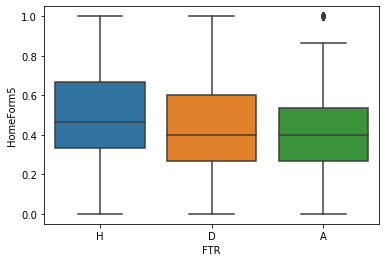

In [561]:
sns.boxplot(x='FTR', y='HomeForm5', data=EPL)

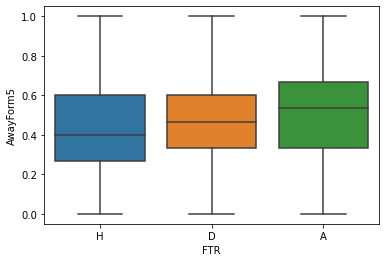

In [562]:
sns.boxplot(x='FTR', y='AwayForm5', data=EPL)